# **Evaluate Synthetic Data**

Quality assessment of generated synthetic questions to ensure they meet specifications before using them for RAG evaluation.

### Key Steps:
1. **Load Data:** Read the generated synthetic questions from CSV
2. **Basic Quality Checks:** Validate sample counts and category distributions
3. **Length Analysis:** Check question length distribution against configuration
4. **Category Balance:** Ensure fair representation across all dimensions
5. **Statistical Validation:** Compare with expected distributions using statistical tests

This notebook helps identify data quality issues early, ensuring high-quality synthetic evaluation data.

In [1]:
import json
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
sns.set_context("talk")  # Increase font sizes

## **Read Data**

In this section, we load the previously generated synthetic data from the CSV file. This data contains:
- Synthetic questions and responses
- Metadata (domain, difficulty, tone, language, groundedness)
- Question embeddings for similarity analysis

The data will be used for comprehensive quality assessment and validation.

In [2]:
fpath='data/synthetic_samples.csv'
df = pd.read_csv(fpath)
df.head(1)

,synthetic_question,explanation,synthetic_response,chunk_id,synthetic_chunk_id,is_grounded,main_chunk,similar_chunks,domain,difficulty,tone,language,question_length,synthetic_question_embedding
0,Does CompactCook Camping Stove come with a man...,"The provided context details product features,...",I don't have information about a manufacturer ...,c34dafd3cd3a_aHR0cHM6Ly9zdG9yYWdlcG92ZWwuYmxvY...,c34dafd3cd3a_aHR0cHM6Ly9zdG9yYWdlcG92ZWwuYmxvY...,False,# Information about product item_number: 20\nC...,"[""# Information about product item_number: 13\...",Related to Customer,Intermediate,Neutral,English,11,"[-0.025468595325946808, -0.01461399719119072, ..."


## **Analysis**

Comprehensive quality assessment covering:
- **Basic checks:** Sample counts and category distributions
- **Length validation:** Word/character counts vs. configuration thresholds
- **Distribution balance:** Bias detection across all dimensions
- **Statistical validation:** Comparison with expected distributions

In [3]:
df_analysis = pd.DataFrame()

### **Basic Quality Checks**

High-level dataset overview: total samples, grounded vs. non-grounded ratio, and category diversity across domains, difficulties, and tones.

In [4]:
# Dataset overview
print("="*50)
print("DATASET OVERVIEW")
print("="*50)
print(f"Total samples: {len(df)}")
print(f"Grounded questions: {df['is_grounded'].sum()}")
print(f"Non-grounded questions: {(~df['is_grounded']).sum()}")
print(f"Unique domains: {df['domain'].nunique()}")
print(f"Unique difficulties: {df['difficulty'].nunique()}")
print(f"Unique tones: {df['tone'].nunique()}")

DATASET OVERVIEW
Total samples: 172
Grounded questions: 88
Non-grounded questions: 84
Unique domains: 2
Unique difficulties: 4
Unique tones: 3


### **Question Length Analysis**

Validates questions against config specifications: Short (30%), Medium (40%), Long (20%), Very Long (10%).
Analysis based on word count.

Expected Length Distribution:
  Short (5-7 words): 30%
  Medium (8-15 words): 40%
  Long (16-25 words): 20%
  Very Long (25+ words): 10%

QUESTION LENGTH STATISTICS (Word Count)
count    172.000000
mean      11.372093
std        4.637872
min        5.000000
25%        8.000000
50%       10.000000
75%       14.000000
max       31.000000


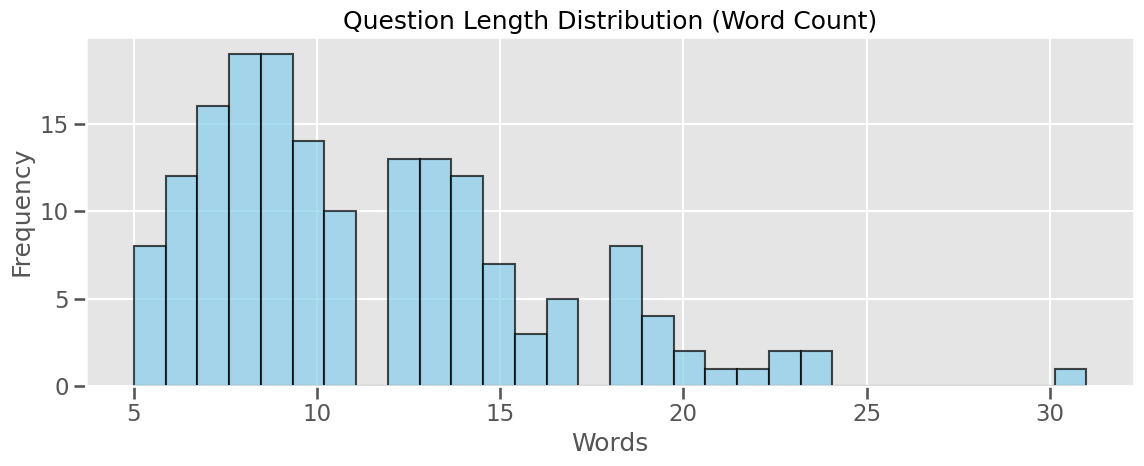

In [5]:
import json

# Load generation config
with open('configs/settings/length_categories.jsonl', 'r') as f:
    length_categories = [json.loads(line) for line in f]

print("Expected Length Distribution:")
for cat in length_categories:
    print(f"  {cat['option']}: {cat['weight']:.0%}")

# Calculate question lengths (word count)
df['q_length'] = df['synthetic_question'].str.split().str.len()

print("\n" + "="*50)
print("QUESTION LENGTH STATISTICS (Word Count)")
print("="*50)
print(df['q_length'].describe().to_string())

# Visualize word count distribution
fig, ax = plt.subplots(figsize=(12, 5))
ax.hist(df['q_length'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
ax.set_title("Question Length Distribution (Word Count)")
ax.set_xlabel("Words")
ax.set_ylabel("Frequency")
plt.tight_layout()
plt.show()

### **Category Distribution Analysis**

Visualizes question distribution across domain, difficulty, tone, groundedness, and language.
Identifies biases, gaps, and imbalances that could affect model training.

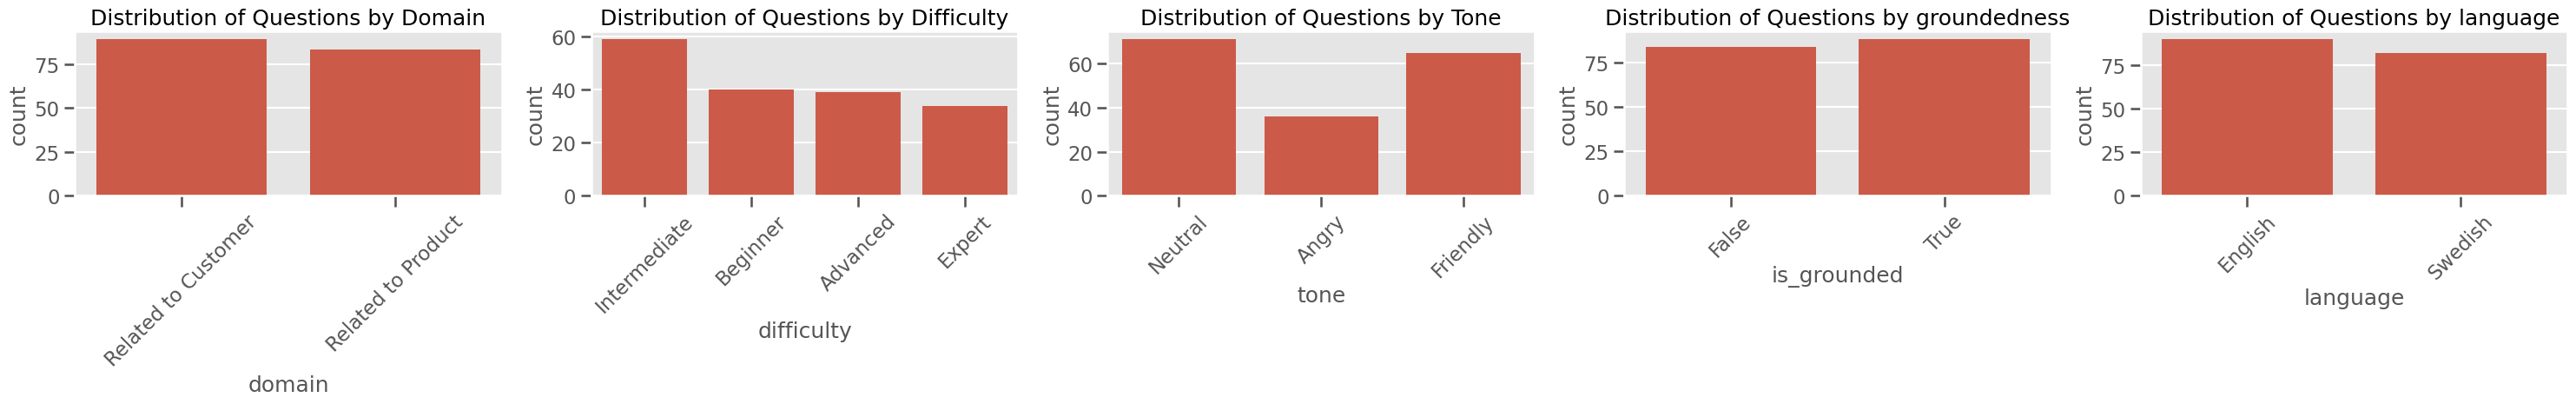

In [6]:
# Create a figure with 3 subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, 5, figsize=(30, 5))  # Adjust figure size as needed

# Plot 1: Distribution by Domain
sns.countplot(data=df, x='domain', ax=axes[0])
axes[0].set_title("Distribution of Questions by Domain")
axes[0].tick_params(axis='x', rotation=45)  # Rotate x-axis labels

# Plot 2: Distribution by Difficulty
sns.countplot(data=df, x='difficulty', ax=axes[1])
axes[1].set_title("Distribution of Questions by Difficulty")
axes[1].tick_params(axis='x', rotation=45)  # Rotate x-axis labels

# Plot 3: Distribution by Tone
sns.countplot(data=df, x='tone', ax=axes[2])
axes[2].set_title("Distribution of Questions by Tone")
axes[2].tick_params(axis='x', rotation=45)  # Rotate x-axis labels

# Plot 4: Distribution by groundedness
sns.countplot(data=df, x='is_grounded', ax=axes[3])
axes[3].set_title("Distribution of Questions by groundedness")
axes[3].tick_params(axis='x', rotation=45)  # Rotate x-axis labels

# Plot 3: Distribution by Tone
sns.countplot(data=df, x='language', ax=axes[4])
axes[4].set_title("Distribution of Questions by language")
axes[4].tick_params(axis='x', rotation=45)  # Rotate x-axis labels

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


### **Length Distribution Validation**

Compares actual question lengths against expected log-normal distribution (μ=2.4, σ=0.42, min=4 words).
Uses visual overlay and Kolmogorov-Smirnov test (p>0.05 = similar distributions).

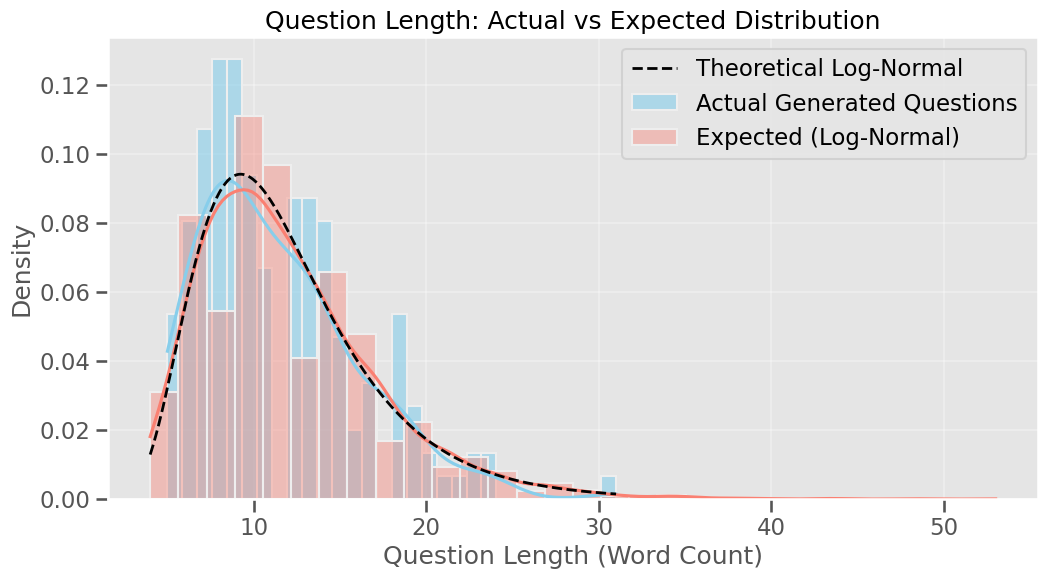


LENGTH DISTRIBUTION VALIDATION
Actual mean: 11.37
Expected mean: 12.02
Actual std: 4.62
Expected std: 5.25

Kolmogorov-Smirnov Test:
  KS Statistic: 0.0672
  P-value: 0.4109
  ✅ Distributions are statistically similar


In [7]:
# Extract actual question lengths from generated data
actual_question_lengths = [len(q.split()) for q in df['synthetic_question']]

# Generate expected distribution based on your sampling parameters
mu = 2.4
sigma = 0.42
min_length = 4
expected_lengths = [max(min_length, int(np.round(np.random.lognormal(mu, sigma)))) 
                   for _ in range(10000)]  # Large sample for smooth curve

# Plot comparison
plt.figure(figsize=(12, 6))

# Actual data
sns.histplot(actual_question_lengths, bins=30, kde=True, color="skyblue", 
             label="Actual Generated Questions", stat="density", alpha=0.6)

# Expected distribution
sns.histplot(expected_lengths, bins=30, kde=True, color="salmon", 
             label="Expected (Log-Normal)", stat="density", alpha=0.4)

# Overlay theoretical log-normal PDF
x = np.linspace(min_length, max(actual_question_lengths), 500)
pdf = (1 / (x * sigma * np.sqrt(2 * np.pi))) * np.exp(-((np.log(x) - mu)**2) / (2 * sigma**2))
plt.plot(x, pdf, color="black", linestyle="--", label="Theoretical Log-Normal", linewidth=2)

plt.title("Question Length: Actual vs Expected Distribution")
plt.xlabel("Question Length (Word Count)")
plt.ylabel("Density")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Statistical comparison
print("\n" + "="*50)
print("LENGTH DISTRIBUTION VALIDATION")
print("="*50)
print(f"Actual mean: {np.mean(actual_question_lengths):.2f}")
print(f"Expected mean: {np.mean(expected_lengths):.2f}")
print(f"Actual std: {np.std(actual_question_lengths):.2f}")
print(f"Expected std: {np.std(expected_lengths):.2f}")

# KS test to check if distributions match
from scipy.stats import ks_2samp
ks_stat, p_value = ks_2samp(actual_question_lengths, expected_lengths)
print(f"\nKolmogorov-Smirnov Test:")
print(f"  KS Statistic: {ks_stat:.4f}")
print(f"  P-value: {p_value:.4f}")
if p_value > 0.05:
    print("  ✅ Distributions are statistically similar")
else:
    print("  ⚠️ Distributions differ significantly")

### **Balance Check**

Verifies fair representation across domain, difficulty, tone, language, and groundedness.
Warns if any category exceeds 60% of samples (potential bias).

In [8]:
print("\n" + "="*50)
print("BALANCE CHECK")
print("="*50)

for col in ['domain', 'difficulty', 'tone', 'language', 'is_grounded']:
    if col in df.columns:
        dist = df[col].value_counts(normalize=True)
        print(f"\n{col.upper()}:")
        for cat, pct in dist.items():
            print(f"  {cat}: {pct:.1%}")
        
        # Warn if any category is over-represented
        if dist.max() > 0.6:
            print(f"  ⚠️ WARNING: '{dist.idxmax()}' is over-represented ({dist.max():.1%})")


BALANCE CHECK

DOMAIN:
  Related to Customer: 51.7%
  Related to Product: 48.3%

DIFFICULTY:
  Intermediate: 34.3%
  Beginner: 23.3%
  Advanced: 22.7%
  Expert: 19.8%

TONE:
  Neutral: 41.3%
  Friendly: 37.8%
  Angry: 20.9%

LANGUAGE:
  English: 52.3%
  Swedish: 47.7%

IS_GROUNDED:
  True: 51.2%
  False: 48.8%
